In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [20]:
X_train = np.load("X_preprocessed.npy")
y_train = np.load("y_preprocessed.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

Y_train = to_categorical(y_train, num_classes=7)
Y_test = to_categorical(y_test, num_classes=7)

print("Training data shape:", X_train.shape)
print("Training labels shape:", Y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", Y_test.shape)


Training data shape: (27473, 48, 48, 1)
Training labels shape: (27473, 7)
Testing data shape: (7178, 48, 48, 1)
Testing labels shape: (7178, 7)


In [21]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=1, verbose=1)


In [22]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)


In [24]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.22))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['acc'])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 44, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,441,223 (5.50 MB)

 Trainable params: 1,441,223 (5.50 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
batch_size = 64
epochs = 40

history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    validation_data=(X_test, Y_test),
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[lr_reduce]
)


Epoch 1/40
430/430 - 94s - 219ms/step - acc: 0.2545 - loss: 1.8099 - val_acc: 0.2544 - val_loss: 1.7954 - learning_rate: 1.0000e-03
Epoch 2/40
430/430 - 103s - 240ms/step - acc: 0.2689 - loss: 1.7661 - val_acc: 0.3277 - val_loss: 1.6878 - learning_rate: 1.0000e-03
Epoch 3/40
430/430 - 95s - 220ms/step - acc: 0.3187 - loss: 1.6926 - val_acc: 0.4026 - val_loss: 1.5543 - learning_rate: 1.0000e-03
Epoch 4/40
430/430 - 93s - 217ms/step - acc: 0.3642 - loss: 1.6100 - val_acc: 0.4252 - val_loss: 1.4825 - learning_rate: 1.0000e-03
Epoch 5/40
430/430 - 87s - 203ms/step - acc: 0.3931 - loss: 1.5429 - val_acc: 0.4582 - val_loss: 1.3968 - learning_rate: 1.0000e-03
Epoch 6/40
430/430 - 88s - 204ms/step - acc: 0.4197 - loss: 1.4902 - val_acc: 0.4776 - val_loss: 1.3534 - learning_rate: 1.0000e-03
Epoch 7/40
430/430 - 89s - 207ms/step - acc: 0.4336 - loss: 1.4504 - val_acc: 0.4909 - val_loss: 1.3189 - learning_rate: 1.0000e-03
Epoch 8/40
430/430 - 92s - 215ms/step - acc: 0.4496 - loss: 1.4150 - val_ac

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5112 - loss: 1.2360
Test Accuracy: 0.58


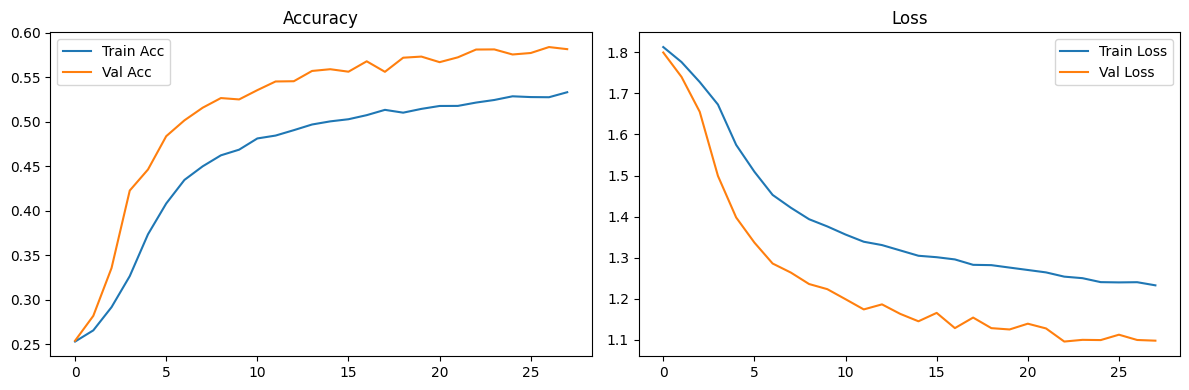

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()


In [26]:
model.save('emotion_detection_model.h5')
